# golive2

## Introduction

### Data summary

The notebook continues the **golive** narrative concerning land ice velocities in southeast Alaska, 
centered around the Malaspina/Seward/Columbus/Bagley/Bering glacier complex.


Whereas **golive** used 6 separate time-series results **golive2** 
improves this to 255 results, again from LANDSAT 8 image pairs from the Path-63 Row-18 frame.
The time range is 2013 day 111 (April 21) through 2018 day 269 (September 26); 5.4 years.
This gives a mean time spacing of 8 days although the effective spacing will be longer.

This appraisal suggests a set of questions/directions

- very complete ice motion map using mean values (compared to sparsity of single results)
- question: What complementary datasets are available? 
  - ice thickness? 
  - surface elevations?
    - as these are available: various dynamic calculations are poosible
      - volume advection estimates / flux gate views
      - sliding speed variability, bed implications
- are synthesized datasets worth building / sharing out? 
  - for example a regularly time-sampled grid of ice speed with NaNs for sparse data 
  - data reduction results such as standard deviation or (standard deviation / mean)
  - Does masking clarify results e.g. by checking velocity direction agreement, invoking `lgo_mask` etc 
    - lgo_mask varies slightly from one result to the next
    - some pixels have unrealistically high velocities (noise)
  - What does 2013 speed / mean speed look like? (2013 shows as higher speed on Seward Glacier)

- Extension to multiple Landsat 8 frames (addressed in the **golive3** notebook)
- Extension to an example region in the Himalayas (**golive4** notebook: S or T 43)


#### Surging


Inspection of time-series speeds on Seward glacier for the 5.4 year time period considered 
here shows consistently modest annual variability. Rapid speed-up / slow-down of the glacier ('surging') is 
not apparent. 


<img src="seward_timeseries.png" alt="drawing" width="500"/>


However: Surge behavior is apparent in GoLIVE data for late spring 2013 on the glacier just 
east of Seward which also feeds the Malaspina piedmont. A location is added to the single-point
time-series charting cell below to illustrate this, giving: 


<img src="surge_timeseries.png" alt="drawing" width="500"/>


The multiple observations of fast speed in late spring of 2013 corroborate the surge as a real
event. They show the ice moving at 10 meters per day and slowing rapidly towards the quiescent 
speeds prevalent for most of the five year interval. 


In contrast the single fast observation in late summer 2017 is uncorroborated and is most
likely spurious. This suggests surge detection could be approached in two ways: Viewing a
flip book animation or devising a detect/corroborate filter. The animation approach would suffer
from the paucity of data in any given frame as the Landsat frame is often obscured by cloud.
The filter approach could be more robust and would apply to larger areas; but may require
considerable time and effort to design and test.


### Methods 


The source data (speed fields from Landsat 8 image pairs) are bundled in NetCDF files.
A traditional approach to working with 255 such results would assign each to a unique
`xarray` Dataset; but this would obviate the native ability of xarray to 
accumulate multi-dimensional data along a new dimension, in this case time. Rather
we use here the `xarray.open_mfdataset()` 'open multiple-file dataset' method to treat the
entire ensemble together. Spatial bounds expand in so doing to encompass
all of the source data. 


The ice speed scalar field is defined everywhere but meaningful only where the processing
algorithm finds a proper correlation. Non-meaningful results include spurious speeds (for
example in excess of 20 meters per day in this region) as well as values `-9999.` and `nan`.
Ideally we want all such locations to have a value `nan` to support additional calculations
such as `.mean()` and `std()` (standard deviation). 


As noted in **golive**: Within this DataSet the DataArray **Data variable** objects include
both scalar speed `vv_masked` and the land/glacier/ocean mask `lgo_mask`. The latter has
values at each pixel of 0, 1 or 2 for glacier, land and ocean respectively. The mask can
be used in an ad hoc manner to filter speed. Mask values may vary between 0 and 1 from one 
result to another in the steep terrain of this region.


The time-slice data files can be seen along the time axis without loading the data into
memory. However this means that time-series analysis across the entire scene will have 
unacceptable latency as files are repeatedly opened and closed. The `xarray.Dataset.load()` 
method circumvents this by reading the DataArray into memory whereupon latency drops to 
negligible. 



## Part 1. Data loader

* Consolidate 255 data files into a single Dataset
* load certain DataArrays into memory

In [1]:
%matplotlib inline

!pip install utm
!pip install pygeotools

import timeit
from datetime import timedelta, datetime
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import dask
import numpy as n
from scipy import stats
from scipy.signal import medfilt as mf
from random import randint as ri

from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import sys
import os
import utm

# from osgeo import gdal 
# from pygeotools.lib import iolib,timelib

import golive_utility as g

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# file grabbing code... this takes a few minutes 

# because the files are redundant: Use the data directory for the golive3 as the source 
golive2_d = g.SetDataDirectory('golive3')

if False:
    ftp = FTP('dtn.rc.colorado.edu')
    ftp.login()
    ftp.cwd('work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r018')
    a=[]
    ftp.dir(a.append)    # This is a rather tricky line of Python as it passes an append method as an argument
    d = [b.split()[8] for b in a if len(b.split()) == 9 and b.split()[8][-3:]=='.nc']
    for i in range(len(d)):
        ftp.retrbinary('RETR ' + d[i], open(golive2_d + d[i], 'wb').write)  
        print('obtained file', i)
    ftp.quit()
    print(len(d))
    # for c in d: print(c)

In [3]:
%%time

# Some 16-day and 48-day interval L8 pairs can have the same center time... so we accumulate these center
#   times as timestamps in a list. When a redundancy happens: Add an hour to the new one so it does not
#   appear simultaneous with the former. Otherwise it is an error in the Dataset compilation. 
tslist = []

def pp(ds):
    global tslist
    s = ds['image_pair_times'].attrs['mid_date']
    ts = pd.Timestamp(s)
    while ts in tslist: ts += timedelta(hours = 1)
    tslist.append(ts)
    ds['time'] = xr.Variable('time', [ts])
    return ds

# Since a 'time' dimension is added in preprocessing: It can be used as the ordering dimension here
m = xr.open_mfdataset(golive2_d + 'L8_063_018*.nc', preprocess = pp, decode_cf=False, autoclose=True, concat_dim='time')

# For 255 files this cell requires about 4 minutes
print('there are', len(tslist), 'files in play')

there are 255 files in play
CPU times: user 3min 22s, sys: 19.4 s, total: 3min 42s
Wall time: 2min 54s


In [4]:
%%time

# print some views of the consolidated dataset 'm'
print(len(m['time']), '\n')
print(type(m['time'].values), '\n')
print(m['time'], '\n')
print(m['image_pair_times'], '\n')
print(m['image_pair_times'].time.values[200], '\n')
print(type(m['corr']), '\n')

# load the two primary DataArrays into memory
vv = m['vv_masked'].load()
lgo = m['lgo_mask'].load()

# Adding a third (for example 'corr') may be too memory intensive for this container
# corr = m['corr'].load()
# north = m['y'].load()
# east = m['x'].load()
# time = m['time'].load()

# This cell takes about 30 seconds

255 

<class 'numpy.ndarray'> 

<xarray.DataArray 'time' (time: 255)>
array(['2013-05-07T00:00:00.000000000', '2013-05-15T00:00:00.000000000',
       '2013-05-23T00:00:00.000000000', ..., '2018-08-25T01:00:00.000000000',
       '2018-09-02T00:00:00.000000000', '2018-09-18T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-05-07 2013-05-15 ... 2018-09-18 

<xarray.DataArray 'image_pair_times' (time: 255)>
array([b'', b'', b'', ..., b'', b'', b''], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2013-05-07 2013-05-15 ... 2018-09-18
Attributes:
    del_t_units:        days
    del_t_speed_units:  m/d 

2017-08-22T00:00:00.000000000 

<class 'xarray.core.dataarray.DataArray'> 

CPU times: user 19.9 s, sys: 6.62 s, total: 26.5 s
Wall time: 15.7 s


## Part 2. Complete time-series charts for glacier centerline


The xarray DataSet `m` covers the entire time series with DataArrays `vv` (speed) and `lgo` (land/glacier/ocean mask) 
in memory, plus some additional (corr, north, east). Again this scene is LANDSAT Path 63 Row 18. 


This section revisits the four transects of Seward Glacier, a medium-sized glacier feeding the Malaspina piedmont lobe.
This extends the six-element time series found in the **golive** notebook to the full 255 elements. 


Some additional deconstruction of the Dataset is included here as well. 


In [5]:
# Endpoints determined via map representing four lateral transects of Seward glacier
ends = []    # a short list of start/endpoints of transects
ends.append(((60.104166,-140.478055),(60.079166,-140.421944)))
ends.append(((60.150833,-140.494444),(60.14611,-140.400277)))
ends.append(((60.189722,-140.456388),(60.17083,-140.389722)))
ends.append(((60.242222,-140.417500),(60.21805,-140.300277)))

# An extra transect is added in here: Longitudinal from the Malaspina tributary 
#   east and south of Seward.
#   This tributary moving very fast and decelerating in the spring of 2014; see fifth chart below.
#     The same chart also shows a single fast result in late summer 2017; which could be real or spurious.
#   Finding this was by chance; it suggests 'surge detection' on a very large scale, restricted only 
#   by L8 processing latency.
ends.append(((60.1,-140.2),(60.0,-140.2)))

nTransects = len(ends)
tr_idcs = range(nTransects)

utm0, utm1 = [], []
for i in tr_idcs:
    utm0.append(utm.from_latlon(ends[i][0][0],ends[i][0][1]))     # UTM coordinates: x, y, long-band, lat-band
    utm1.append(utm.from_latlon(ends[i][1][0],ends[i][1][1]))

from numpy.linalg import norm
posting = 100.                         # meters between points in the transect

# The following lists have index across the various transects
transects = [(utm1[i][0]-utm0[i][0], utm1[i][1]-utm0[i][1]) for i in tr_idcs]   # two endpoints of the transect
lengths = [norm(transects[i]) for i in tr_idcs]                                 # lengths of those two-endpoint vectors
relative_postings = [transects[i]/lengths[i]*posting for i in tr_idcs]          # hop vector for running the transect
number_of_postings = [int(lengths[i]/posting) + 1 for i in tr_idcs]             # number of postings (hops) in the transect

print(transects, '\n')
print(lengths, '\n')
print(relative_postings, '\n')
print(number_of_postings, '\n')

[(3144.1744930562563, -2758.1968929581344), (5233.141818051343, -482.24623928405344), (3716.5123229203746, -2071.6535719921812), (6518.903660722659, -2628.9233719613403), (134.7367960573174, -11136.31311713159)] 

[4182.521170670804, 5255.314902376576, 4254.904507596729, 7029.03571149186, 11137.128168743006] 

[array([ 75.17414413, -65.94579634]), array([99.57808267, -9.17635286]), array([ 87.3465507 , -48.68860319]), array([ 92.74250307, -37.40091073]), array([  1.20979838, -99.99268167])] 

[42, 53, 43, 71, 112] 



CPU times: user 145 ms, sys: 0 ns, total: 145 ms
Wall time: 143 ms


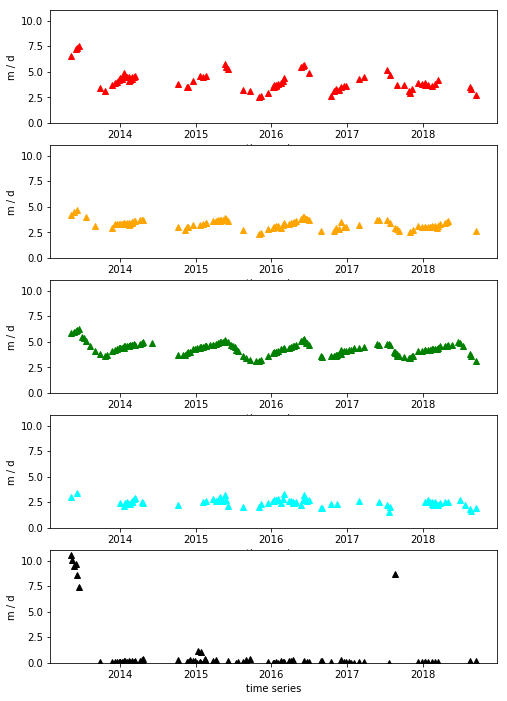

In [6]:
%%time
# Create time-series plots for speeds at the centers of the above four respective lateral transects

# Remember that n16s is how many 16-day-interval results we have; and these are m[0], ..., m[n16s - 1]
timestamps = vv['time']
maxSpeed = 11.
colorsequence = ['red', 'orange', 'green', 'cyan', 'black', 'blue', 'yellow']
fig, axes = plt.subplots(nTransects)
fig.set_size_inches(8,12)
for i in tr_idcs: axes[i].set(ylim=(0., maxSpeed), xlabel='time series', ylabel = 'm / d')

for t in tr_idcs: 
    xMid = utm0[t][0] + (number_of_postings[t]/2.)*relative_postings[t][0]    # These must start at utm0 and add a certain 
    yMid = utm0[t][1] + (number_of_postings[t]/2.)*relative_postings[t][1]    #   number of the relative_postings vectors
    y = vv.sel(y=yMid,x=xMid,method='nearest').values 
    axes[t].plot(timestamps, y, '^', color=colorsequence[t])  
    
# changing the plot type string from triangles '^' to connected triangles '^-' indicates spurious data:
#   -9999 values and errors in speed cause chart lines to dart down / up respectively

#### Interpretation


As noted at the top the Seward time series shows modest cyclic annual variability in speed. This is 
consistent with the heuristic idea that glaciers accelerate in the spring as melting water (denser
than ice) makes its way to the glacier bed, facilitating faster sliding speeds. The shape of the 
speed profile is coincidentally reminiscent of the Keeling curve tracking atmospheric CO2.


<img src="keeling.png" alt="drawing" width="450"/>



The fifth chart above, as noted in the *Introduction*, indicates that the glacier east of Seward
was moving very fast -- 10 meters per day -- in late spring 2013, rapidly decelerating to a 
quiescent state. By examining the results around late summer 2017 we see that the single fast
speed shown is spurious. 

In [7]:
# This cell establishes that the lgo_mask varies in time
if False:
    xice = 702
    yice = 402
    for i in range(10):                                          # time slices
        lgoval = lgo.isel(y=yice,x=xice,time=i).values           # most 0 (glacier) but one 1 (land)
        vvval = vv.isel(y=yice,x=xice,time=i).values             # some 'no data' values at -9999.
        corrval = corr.isel(y=yice,x=xice,time=i).values         # ranges .51 to .89
        northval = north.isel(y=yice).values                     # consistent
        eastval = east.isel(x=xice).values                       # consistent
        print(lgoval, vvval, corrval, northval, eastval)

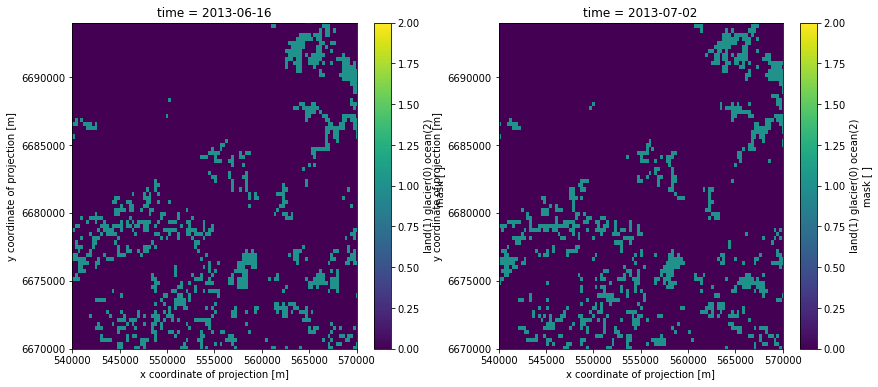

In [8]:
# lgo_mask with consecutive times: Slight differences apparent
# This makes it intrinsically more difficult to settle on a set of for-sure-this-is-moving-ice pixels
if True:
    fig,axes = plt.subplots(1, 2)
    lgo.isel(time=5).plot(ax=axes[0])
    lgo.isel(time=6).plot(ax=axes[1])
    fig.set_size_inches(14,6)
    axes[0].set(xlim=(540000,570000),ylim=(6670000,6694000))
    axes[1].set(xlim=(540000,570000),ylim=(6670000,6694000))

In [9]:
# lgo has both Parameters (particularly 'data') and Attributes (particularly 'values')
if False: 
    print(lgo.data)
    print('\n ------------------- \n')
    print(lgo.values)

## Part 3. Entire-scene analysis

* Using the entire scene is the objective
  * Start with a single UTM coordinate: center of first transect shown above
  * integer indices? (open challenge)
  * Subsets of DataArrays are DataArrays
    * ...but .data or .values are numpy ndarrays (immutable vectors)
    * 'lists without commas'
* Verify no-data value = -9999. and convert these to nan
* Use xarray.DataArray.mean(dim) and .std(dim) where dim indicates axis of the calculation
  * ...and verify!
* Count how many good data values
* Count lgo glacier values

In [10]:
print(vv.shape)

(255, 829, 840)


In [11]:
# suppress warnings but better would be to work out the logic and improve the code so as to not get warnings
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

In [12]:
vv.to_netcdf('../data/golive3/go_speed.nc')
lgo.to_netcdf('../data/golive3/go_lgo.nc')

In [13]:
# lgo_mask with consecutive times: Slight differences apparent
# This makes it intrinsically more difficult to settle on a set of for-sure-this-is-moving-ice pixels
def CompareSnapshotToMean(maxSpeed):
    
    iceThresholdAdHoc = 0.5
    timeSelectAdHoc = 0
    
    lgo_part1 = lgo.where(lgo.data < 2.)
    lgo_part2 = lgo_part1.mean('time')

    vv_snap1 = vv.isel(time=timeSelectAdHoc)
    vv_snap2 = vv_snap1.where(vv_snap1.data >= 0.)
    vv_snap3 = vv_snap2.where(vv_snap2.data <= 14.)
    vv_snap4 = vv_snap3.where(lgo_part2.data <= iceThresholdAdHoc)
    
    vv_mean1=vv.where(vv.data >= 0.)
    vv_mean2=vv_mean1.where(vv_mean1.data <= 14.)
    vv_mean3=vv_mean2.mean('time')
    vv_mean4=vv_mean3.where(lgo_part2.data <= iceThresholdAdHoc)
    
    fig,axes = plt.subplots(2, 1)
    vv_snap4.plot(ax=axes[0],cmap=plt.cm.rainbow,vmin=0.0, vmax=maxSpeed)
    vv_mean4.plot(ax=axes[1],cmap=plt.cm.rainbow,vmin=0.0, vmax=maxSpeed)
    fig.set_size_inches(14,22)
    axes[0].set(xlim=(480000,570000), ylim=(6630000,6694000))
    axes[1].set(xlim=(480000,570000), ylim=(6630000,6694000))
    
    
interact(CompareSnapshotToMean, maxSpeed=widgets.FloatSlider(min=0.025, max=20., step=.025, \
                                    value=8.0, continuous_update=False, \
                                    readout_format='1.4f', description='max speed'))

interactive(children=(FloatSlider(value=8.0, continuous_update=False, description='max speed', max=20.0, min=0…

<function __main__.CompareSnapshotToMean>

In [14]:
def PlotSubregion(speed, a, b, c, d, timeSelect, vMax):
    fig,axes = plt.subplots()
    speed.isel(time=timeSelect).plot(ax=axes,cmap=plt.cm.rainbow,vmin=0.0, vmax=vMax)
    fig.set_size_inches(14,8)
    axes.set(xlim=(a,c), ylim=(b,d))

def go(timeSelector, vMax): 
    a,c,b,d = 480000,570000,6630000,6694000
    PlotSubregion(vv, a, b, c, d, timeSelector, vMax)
    
interact(go, timeSelector=widgets.IntSlider(min=0,max=254,step=1,value=0, continuous_update=False, description='image index'),       
             vMax=widgets.FloatSlider(min=0.05, max=20., step=.025, value=8.0, continuous_update=False, \
                                      readout_format='1.4f', description='max speed'))

interactive(children=(IntSlider(value=0, continuous_update=False, description='image index', max=254), FloatSl…

<function __main__.go>

In [15]:
a=float('nan')
print(a)
print(a+a)
print(np.isnan(a))

nan
nan
True


In [16]:
vv1=vv.where(vv.data >= 0.)
vv_band_1=vv1.where(vv1.data < 20.)

print(vv_band_1.shape)
# and lgo.data.any('time')<1.0)

def go(timeSelector, vMax): 
    a,c,b,d = 480000,570000,6630000,6694000
    PlotSubregion(vv_band_1, a, b, c, d, timeSelector, vMax)
    
interact(go, timeSelector=widgets.IntSlider(min=0,max=254,step=1,value=0, continuous_update=False, \
                                            description='image index'),       
             vMax=widgets.FloatSlider(min=0.05, max=20., step=.025, value=8.0, continuous_update=False, \
                                      readout_format='1.4f', description='max speed'))

(255, 829, 840)


interactive(children=(IntSlider(value=0, continuous_update=False, description='image index', max=254), FloatSl…

<function __main__.go>

In [17]:
vv2=vv.where(vv.data >= 0.)
vv_band_2=vv2.where(vv2.data < 10.)

def go(timeSelector, vMax): 
    a,c,b,d = 480000,570000,6630000,6694000
    PlotSubregion(vv_band_2, a, b, c, d, timeSelector, vMax)
    
interact(go, timeSelector=widgets.IntSlider(min=0,max=254,step=1,value=0, continuous_update=False, \
                                            description='image index'),       
             vMax=widgets.FloatSlider(min=0.05, max=20., step=.025, value=8.0, continuous_update=False, \
                                      readout_format='1.4f', description='max speed'))

interactive(children=(IntSlider(value=0, continuous_update=False, description='image index', max=254), FloatSl…

<function __main__.go>

In [18]:
vv1=vv.where(vv.data >= 0.).mean('time')
vv2=vv.where(vv.data >= 0.).std('time')

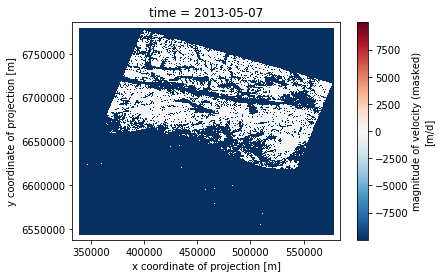

In [19]:
vv.isel(time=0).plot()
fig.set_size_inches(14,10)

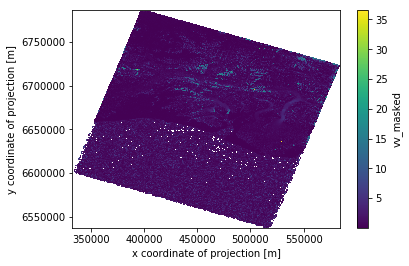

In [20]:
vv1.plot()
fig.set_size_inches(14,10)

In [21]:
print(vv1.isel(x=537,y=319).data)
print(vv2.isel(x=537,y=319).data)

0.08344171
0.097960316


In [22]:
vv3=vv2/vv1
vv3.shape

(829, 840)

In [23]:
vv4 = vv3.where(vv3.data < 2.0)
vv5 = vv4.where(vv4.data > 0.05)
vv6 = vv5.where(lgo4.data >= 0.0)
vv6.plot(figsize=(14,10),cmap=plt.cm.rainbow,vmin=0.05, vmax=2.0)
plt.xlim(440000,550000)
plt.ylim(6630000,6730000)

NameError: name 'lgo4' is not defined

In [ ]:
vvlgo1 = vv1.where(lgo4.data >= 0.)
vvlgo1.plot(figsize=(14,10),cmap=plt.cm.rainbow,vmin=0.05, vmax=2.0)
plt.xlim(440000,550000)
plt.ylim(6630000,6730000)